In [1]:
import sys
sys.path.append('../src')

import pickle

import torch
import torch.nn.functional as F
import random

from torch.nn import Linear, Sequential, BatchNorm1d, ReLU
import torch_geometric
from torch_geometric.explain import Explainer
from torch_geometric.nn import SAGEConv, GATConv, GINConv, GIN, GCNConv
from cf_explainer import C2NodeExplainer
from cf_explainer import C2Explainer
from torch_geometric.nn import global_mean_pool,  global_max_pool
from cf_explainer.utils import seed_everything

import numpy as np

# import networkx as nx
# from pyvis.network import Network

from tqdm.auto import tqdm

import pickle

'''Config parameters'''
use_cuda_if_available = True
device = torch.device('cuda' if torch.cuda.is_available() and use_cuda_if_available else 'cpu')

# seed_everything(42, deterministic=True)
# if error when setting use_deterministic_algorithms(True)
# try this:
%env CUBLAS_WORKSPACE_CONFIG=:4096:8

print("PyTorch version:", torch.__version__)
print("PyTorch device:", device)

env: CUBLAS_WORKSPACE_CONFIG=:4096:8
PyTorch version: 2.0.1
PyTorch device: cuda


In [2]:
def results(num_perturbs, prop_perturbs):
    print("######")
    if len(num_perturbs) != 0:
        size = sum(num_perturbs)/(2*len(num_perturbs))
        prop = sum(prop_perturbs)/len(prop_perturbs)
    else:
        size = "N/A"
        prop = "N/A"
    print(f"size: {size}, num_success: {len(num_perturbs)}, prop_perturbs: {prop}")
    print("finished")
    return size, prop


def explain(model, dataset, explainer, seed=42):
    seed_everything(seed, deterministic=True)
    result = []
    
    explainer = Explainer(
        model=model,
        algorithm=explainer,
        explanation_type='model',
        node_mask_type=None,
        edge_mask_type='object',
        model_config=dict(
            mode='multiclass_classification',
            task_level='graph',
            return_type='raw',
        ), 
    )
    
    cfs = []
    origs = []
    num_perturbs = []
    prop_perturbs = []

    for data in tqdm(test_dataset):
        explanation = explainer(data.x, data.edge_index, batch=None)
        
        if hasattr(explanation, "perturbs"):
            if explanation.perturbs < 20:
                cfs.append((data.x, explanation.cf))
                origs.append((data.x, data.edge_index))
                num_perturbs.append(explanation.perturbs)
                prop_perturbs.append(explanation.prop_perturbs)
    
    size, prop = results(num_perturbs, prop_perturbs)
    
    result.append([len(test_dataset), size, len(num_perturbs), prop])
    print(f"Fedility: {len(num_perturbs)/len(test_dataset)}, Num_perturbs: {size}, Similarity: {1-prop}")
    return result, cfs, origs

# MUTAG

In [3]:
class GCN(torch.nn.Module):
    def __init__(self, nhid, nout, dropout):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(7, nhid, normalize=False)
        self.conv2 = GCNConv(nhid, nhid, normalize=False)
        self.conv3 = GCNConv(nhid, nout, normalize=False)
        self.lin = Linear(nout, 2)
        self.dropout = dropout

    def forward(self, x, edge_index, batch, edge_weight=None):
        # 1. Obtain node embeddings 
        x = self.conv1(x, edge_index, edge_weight)
        x = x.relu()
        x = self.conv2(x, edge_index, edge_weight)
        x = x.relu()
        x = self.conv3(x, edge_index, edge_weight)

        # 2. Readout layer
        x = global_max_pool(x, batch)  # [batch_size, nhid]

        # 3. Apply a final classifier
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.lin(x)
        
        return x

model = GCN(nhid=20, nout=20, dropout=0).to(device)
model.load_state_dict(torch.load("../models/GCN_MUTAG_sd.pt", weights_only=True))

with open("../data/MUTAG.pickle", "rb") as f:
	dataset = pickle.load(f)

torch.manual_seed(42)
dataset = dataset.shuffle()

train_dataset = dataset[:0.8]
test_dataset = dataset[0.8:]

/home/ymmt4090no1/miniconda3/envs/pyg/lib/python3.10/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [4]:
%%time
explainer = C2NodeExplainer(epochs=1000, lr=0.1, beta=1, 
                            silent_mode=True, undirected=True, print_loss=False)

result, cfs, origs = explain(model, test_dataset, explainer, seed=42)

  0%|          | 0/38 [00:00<?, ?it/s]

######
size: 2.757575757575758, num_success: 33, prop_perturbs: 0.14864683846849183
finished
Fedility: 0.868421052631579, Num_perturbs: 2.757575757575758, Similarity: 0.8513531615315082
CPU times: user 1min 44s, sys: 263 ms, total: 1min 44s
Wall time: 1min 46s


In [5]:
%matplotlib inline
import networkx as nx
import matplotlib.pyplot as plt

def visualize_graph(G, color, pos=None, title=None):
    plt.figure(figsize=(7,7))
    plt.title(title)
    plt.xticks([])
    plt.yticks([])
    
    if pos is None:
        pos = nx.spring_layout(G, seed=42)
    nx.draw_networkx(G, pos=pos, with_labels=True,
                     node_color=color, cmap="Set2")
    plt.show()

In [6]:
%matplotlib inline
import networkx as nx
import matplotlib.pyplot as plt


def visualize_graph(G, color, pos=None, title=None):
    plt.figure(figsize=(7,7))
    plt.title(title)
    plt.xticks([])
    plt.yticks([])
    
    if pos is None:
        pos = nx.spring_layout(G, seed=42)
    nx.draw_networkx(G, pos=pos, with_labels=True,
                     node_color=color, cmap="Set2")
    plt.show()

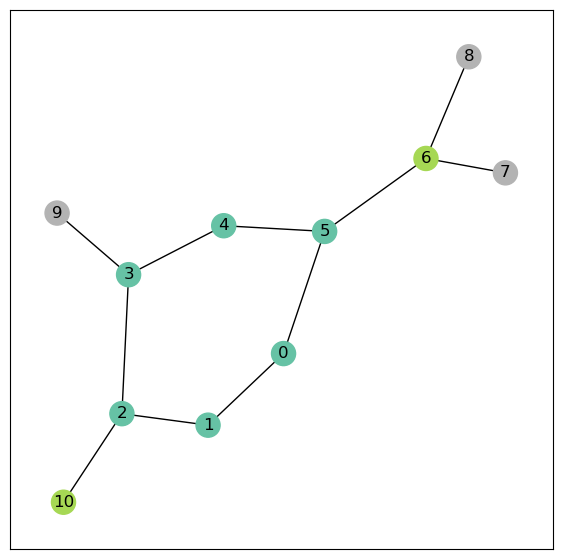

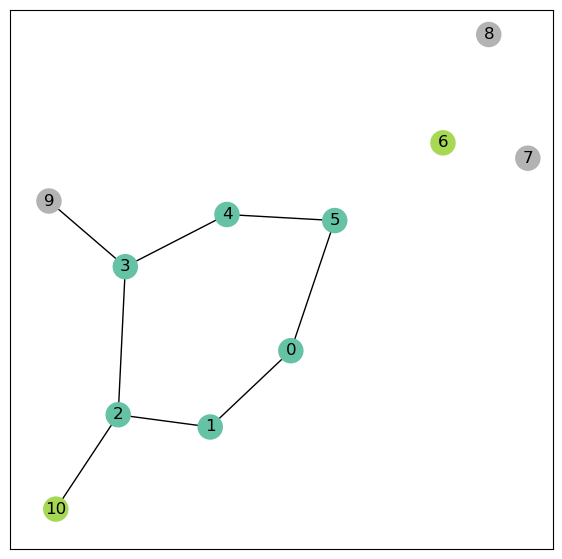

In [7]:
from torch_geometric.data import Data
from torch_geometric.utils import to_networkx

color_dict= {0:"Red", 1:"Blue", 2:"Yellow",3:"Green", 
             4:"Gray", 5:"Purple", 6:"Pink"}

i = 17

data = Data(x=origs[i][0], edge_index=origs[i][1])
color = torch.argmax(origs[i][0],axis=1).to("cpu")

G = to_networkx(data, to_undirected=True)
pos = nx.spring_layout(G, iterations=1000, seed = 42)
visualize_graph(G, color=color, pos=pos, title = None)

data = Data(x=cfs[i][0], edge_index=cfs[i][1])
G = to_networkx(data, to_undirected=True)
# pos = nx.spring_layout(G, iterations=100, seed = 42)
visualize_graph(G, color=color, pos=pos, title = None)

Node labels:

  0  C
  1  N
  2  O
  3  F
  4  I
  5  Cl
  6  Br

Edge labels:

  0  aromatic
  1  single
  2  double
  3  triple

In [8]:
%%time
explainer = C2Explainer(epochs=1000, lr=0.1, subgraph_mode=True, silent_mode=True, undirected=True)

result2, cfs2, origs2 = explain(model, test_dataset, explainer, seed=42)

  0%|          | 0/38 [00:00<?, ?it/s]

######
size: 2.121212121212121, num_success: 33, prop_perturbs: 0.12041421982233662
finished
Fedility: 0.868421052631579, Num_perturbs: 2.121212121212121, Similarity: 0.8795857801776634
CPU times: user 1min 38s, sys: 217 ms, total: 1min 38s
Wall time: 1min 40s


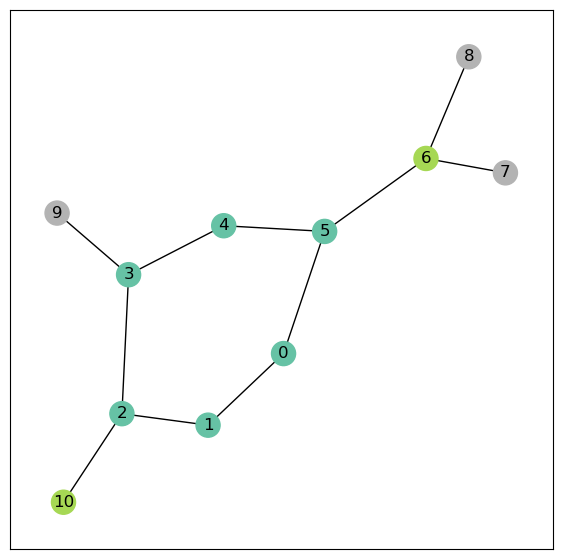

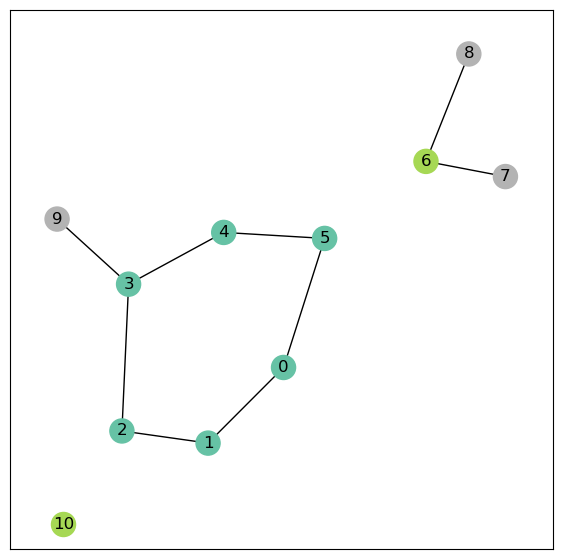

In [9]:
from torch_geometric.data import Data
from torch_geometric.utils import to_networkx

color_dict= {0:"Red", 1:"Blue", 2:"Yellow",3:"Green", 
             4:"Gray", 5:"Purple", 6:"Pink"}

i = 18

data = Data(x=origs2[i][0], edge_index=origs2[i][1])
color = torch.argmax(origs2[i][0],axis=1).to("cpu")

G = to_networkx(data, to_undirected=True)
pos = nx.spring_layout(G, iterations=1000, seed = 42)
visualize_graph(G, color=color, pos=pos, title = None)

data = Data(x=cfs2[i][0], edge_index=cfs2[i][1])
G = to_networkx(data, to_undirected=True)
# pos = nx.spring_layout(G, iterations=100, seed = 42)
visualize_graph(G, color=color, pos=pos, title = None)